In [1]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from matplotlib import rc

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np


In [8]:
상폐 = pd.read_csv('상폐기업_감성분석_데이터.csv')
상폐 = 상폐.iloc[:,[0, 1, 2, 3, 4, 5, 6, 9, 8]]
정상 = pd.read_csv('정상기업_감성분석_데이터.csv')
정상 = 정상.iloc[:,[0, 1, 2, 3, 4, 5, 6, 9, 8]]

감성분석_재무비율 = pd.concat([상폐, 정상])
감성분석_재무비율.reset_index(inplace=True, drop=True)
감성분석_재무비율.to_csv('감성분석_재무비율.csv', index=None)

In [2]:
np.random.seed(42)

부도비율 = pd.read_csv('./Step4-3_재무비율_워드임베딩_모델링/mecab_word2vec_재무비율.csv')
부도비율.rename(columns={'운전자산총자본비율':'운전자본비율'}, inplace=True)

감성분석 = pd.read_csv('Step5-2_감성분석_모델링/감성분석_재무비율.csv')
감성분석.rename(columns={'운전자산총자본비율':'운전자본비율'}, inplace=True)

data = 부도비율
data['부정기사비율'] = 감성분석.부정기사비율
data.fillna(0, inplace=True)
input = data.iloc[:,[2, 3, 4, 5, 6, 7, 9]]
target = data.iloc[:,8]

In [22]:
data = data.iloc[:,[0,1,2,3,4,5,6,7,9,8]]
data.to_csv('재무_부도_부정.csv', index=None, encoding='utf-8-sig')

In [8]:
corr_df = data.iloc[:,2:9].corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,운전자본비율,이익잉여금총자산비율,총자산이익율,시장가부채비율,매출액회전율,부도기사비율,부정기사비율
운전자본비율,1.00,0.18,0.43,0.62,-0.03,-0.21,-0.24
이익잉여금총자산비율,0.18,1.00,0.53,0.16,0.14,-0.22,-0.28
총자산이익율,0.43,0.53,1.00,0.22,0.25,-0.35,-0.41
시장가부채비율,0.62,0.16,0.22,1.00,-0.16,-0.14,-0.10
매출액회전율,-0.03,0.14,0.25,-0.16,1.00,-0.11,-0.14
부도기사비율,-0.21,-0.22,-0.35,-0.14,-0.11,1.00,0.53
부정기사비율,-0.24,-0.28,-0.41,-0.10,-0.14,0.53,1.00


<AxesSubplot:>

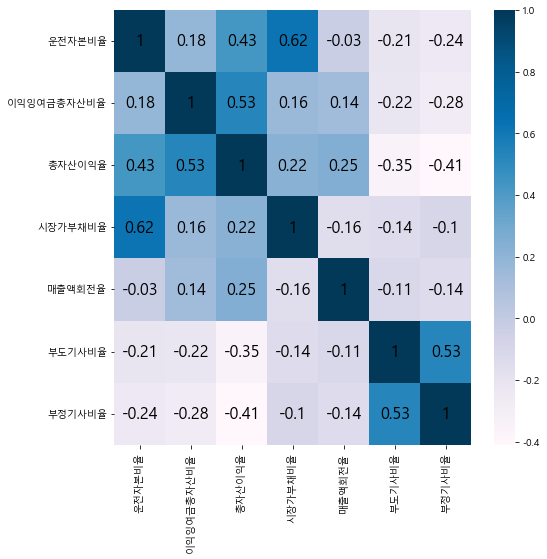

In [21]:
plt.figure(figsize=(8,8))
plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
sns.heatmap(corr_df, annot=True, annot_kws=dict(color='black', size=16), cmap = plt.cm.PuBu)


In [ ]:
부실기업부정기사비율 = np.mean(data[data.부실기업여부==1].부정기사비율)
정상기업부정기사비율 = np.mean(data[data.부실기업여부==0].부정기사비율)
부정기사비율차이 = 부실기업부정기사비율 - 정상기업부정기사비율

print(f'부실기업의 부정기사 비율 : {부실기업부정기사비율}')
print(f'정상기업의 부정기사 비율 : {정상기업부정기사비율}')
print(f'부정기사 비율의 차이 : {부정기사비율차이}')

부실기업의 부정기사 비율 : 29.711582791883014
정상기업의 부정기사 비율 : 13.883113450994268
부정기사 비율의 차이 : 15.828469340888747


## XGBClassifier
##### 설명 참고 : https://wooono.tistory.com/97

In [24]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

xgb = XGBClassifier(random_state=42)

xgb_param_grid = {'n_estimators' : [100, 200],
                'learning_rate' : [0.01, 0.05, 0.1],
                'max_depth' : [3, 5, 7],
                'gamma' : [0, 1, 2]}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
xgb_grid.fit(x_train, y_train)

print(f'best f1 : {xgb_grid.best_score_}')
print('best param : ', xgb_grid.best_params_)

## 참고 : https://cjh34544.tistory.com/m/4
## http://aispiration.com/model/model-python-xgboost-hyper.html

best f1 : 0.9352420306965762
best param :  {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [24]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

xgb = XGBClassifier(random_state=42)

xgb_param_grid = {'n_estimators' : [100, 200],
                'learning_rate' : [0.01, 0.05, 0.1],
                'max_depth' : [3, 5, 7],
                'gamma' : [0, 1, 2]}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
xgb_grid.fit(x_train, y_train)

print(f'best f1 : {xgb_grid.best_score_}')
print('best param : ', xgb_grid.best_params_)

## 참고 : https://cjh34544.tistory.com/m/4
## http://aispiration.com/model/model-python-xgboost-hyper.html

best f1 : 0.8905352223534042
best param :  {'gamma': 2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


## Logistic

In [25]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

lr = LogisticRegression(random_state=42)

lr_param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
                'penalty' : ['l1', 'l2']}

lr_grid = GridSearchCV(lr, param_grid=lr_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
lr_grid.fit(x_train, y_train)

print(f'best f1 : {lr_grid.best_score_}')
print('best param : ', lr_grid.best_params_)

# 참고 : https://wikidocs.net/16594


best f1 : 0.9548799685163321
best param :  {'C': 0.1, 'penalty': 'l2'}


C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\dbswo\AppData\Local\Programs\Python\

In [26]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

lr = LogisticRegression(random_state=42)

lr_param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
                'penalty' : ['l1', 'l2']}

lr_grid = GridSearchCV(lr, param_grid=lr_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
lr_grid.fit(x_train, y_train)

print(f'best f1 : {lr_grid.best_score_}')
print('best param : ', lr_grid.best_params_)

# 참고 : https://wikidocs.net/16594

best f1 : 0.9005312868949232
best param :  {'C': 0.01, 'penalty': 'l2'}


C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\dbswo\AppData\Local\Programs\Python\

## RandomForest

In [26]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators' : [100, 200],
                'max_depth' : [3, 5, 7],
                'min_samples_leaf' : [8, 12, 16],
                'min_samples_split' : [8, 16, 20]}

rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
rf_grid.fit(x_train, y_train)

print(f'best f1 : {rf_grid.best_score_}')
print('best param : ', rf_grid.best_params_)

## 참고 : https://techblog-history-younghunjo1.tistory.com/102
## https://jaaamj.tistory.com/35


best f1 : 0.9497441951987406
best param :  {'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 100}


In [28]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators' : [100, 200],
                'max_depth' : [3, 5, 7],
                'min_samples_leaf' : [8, 12, 16],
                'min_samples_split' : [8, 16, 20]}

rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
rf_grid.fit(x_train, y_train)

print(f'best f1 : {rf_grid.best_score_}')
print('best param : ', rf_grid.best_params_)

## 참고 : https://techblog-history-younghunjo1.tistory.com/102
## https://jaaamj.tistory.com/35

best f1 : 0.9028335301062574
best param :  {'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 100}


## SVM

In [6]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

svc = SVC(random_state=42)

svc_param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
                'gamma' : [0.001, 0.01, 0.1, 1, 10]}

svc_grid = GridSearchCV(svc, param_grid=svc_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
svc_grid.fit(x_train, y_train)

print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)

best f1 : 0.9570444706808343
best param :  {'C': 1, 'gamma': 0.01}


In [30]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

svc = SVC(random_state=42)

svc_param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
                'gamma' : [0.001, 0.01, 0.1, 1, 10]}

svc_grid = GridSearchCV(svc, param_grid=svc_param_grid, scoring='roc_auc', verbose=0, n_jobs=1)
svc_grid.fit(x_train, y_train)

print(f'best f1 : {svc_grid.best_score_}')
print('best param : ', svc_grid.best_params_)

best f1 : 0.7387137055783515
best param :  {'C': 1, 'gamma': 0.001}


### CatBoostClassifier는 파라미터 조정이 성능에 크게 영향을 미치지 않는다는 말이 많아 일단 생략함
##### https://velog.io/@jus6886/Catboost
##### https://undeadkwandoll.tistory.com/61
##### https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002698429
#### CatBoost 설명
##### https://dailyheumsi.tistory.com/136
##### https://techblog-history-younghunjo1.tistory.com/199
##### https://heeya-stupidbutstudying.tistory.com/43?category=950711

In [29]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(x_train, y_train)
pred = cat.predict(x_test)

acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
roc = roc_auc_score(y_test, pred)

print(roc)

0.7774725274725274


#### Boosting Model 비교
##### https://medium.com/@divyagera2402/boosting-algorithms-adaboost-gradient-boosting-xgb-light-gbm-and-catboost-e7d2dbc4e4ca
##### http://dmqm.korea.ac.kr/activity/seminar/323
##### https://hyunlee103.tistory.com/25
##### https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm




#### 한 것요약
##### 원핫인코딩은 차원을 늘려 과적합되기 쉽다. 물론 규제로 어느정도 커버할 수 있으나 트리계열에서는 해당 변수가 아예 제외되는 문제점을 가진다. 차원의 저주 등등
##### catboost는 파라미터 수정을 하지 않아도 효과가 나쁘지 않다
##### lightgbm은 데이터의 수가 너무 적어 사용할 수 없다
##### ROC가 F1보다 불균형 데이터 셋에 대해 관대한? 경향이 있어서 불균형 데이터 셋에는 F1을 평가지표로 사용한다.
